# Municipal Internet Speed Status

In [3]:
%load_ext autoreload
%autoreload 2

In [38]:
import zipfile
from pathlib import Path
import json

import numpy as np

import rasterio
import fiona
import matplotlib.pyplot as plt
import math

plt.rcParams["figure.figsize"]=20,50

from utils import download, point_in_db, fiona_to_index, get_municipal_dataset

## Fetch data files

In [5]:
DATA = Path('./data')
DATA.mkdir(exist_ok=True)

# Download Municipal borders from geoboundaries.org
MUNI_BORDERS_URL = 'https://raw.githubusercontent.com/wmgeolab/geoBoundaries/76db2f88fa74edfcbe092e9b4df9ae843181dae3/releaseData/gbOpen/ISR/ADM2/geoBoundaries-ISR-ADM2-all.zip'
MUNI_BORDERS_ZIP = download(MUNI_BORDERS_URL, DATA / 'geoBoundaries-ISR-ADM2-all.zip')
zipfile.ZipFile(MUNI_BORDERS_ZIP).extract('geoBoundaries-ISR-ADM2.geojson', DATA)
MUNI_BORDERS = DATA / 'geoBoundaries-ISR-ADM2.geojson'

# Download Population estimate data from WorldPop
POP_DATA = download('https://data.worldpop.org/GIS/Population/Global_2000_2020_Constrained/2020/BSGM/ISR/isr_ppp_2020_constrained.tif', DATA / 'isr_ppp_2020_constrained.tif')

# Ookla Data
FIXED_DATA_ZIP = download('https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=fixed/year=2021/quarter=4/2021-10-01_performance_fixed_tiles.zip', DATA / 'fixed_ookla.zip')
MOBILE_DATA_ZIP = download('https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=mobile/year=2021/quarter=4/2021-10-01_performance_mobile_tiles.zip', DATA / 'mobile_ookla.zip')
zipfile.ZipFile(FIXED_DATA_ZIP).extractall(DATA)
zipfile.ZipFile(MOBILE_DATA_ZIP).extractall(DATA)

FIXED_DATA = DATA / 'gps_fixed_tiles.shp'
MOBILE_DATA = DATA / 'gps_mobile_tiles.shp'

In [4]:
municipalities = dict()

pop_dataset = rasterio.open(POP_DATA)
pop_data = pop_dataset.read(1)

muni_dataset = fiona.open(MUNI_BORDERS)
ookla = dict(
    fixed=fiona_to_index(fiona.open(FIXED_DATA), pop_dataset.bounds),
    mobile=fiona_to_index(fiona.open(MOBILE_DATA), pop_dataset.bounds)
)

pop_indexes = np.argwhere(pop_data > 0)
next_i = 1
count = 0
for i, (pop_x, pop_y) in enumerate(pop_indexes):
    pop_value = pop_data[pop_x, pop_y]
    coordinates = pop_dataset.xy(pop_x, pop_y)
    muni = point_in_db(coordinates, muni_dataset)
    if muni is not None:
        muni_name = muni['shapeName']
        muni_rec = municipalities.setdefault(muni_name, dict(
            name=muni_name,
            pop=0,
            fixed=dict(u=0, d=0, l=0, p=0),
            mobile=dict(u=0, d=0, l=0, p=0)
        ))
        muni_rec['pop'] += pop_value
        for k in ['fixed', 'mobile']:
            ookla_data = point_in_db(coordinates, ookla[k])
            if ookla_data is not None:
                muni_rec[k]['u'] += ookla_data['avg_u_kbps'] * pop_value
                muni_rec[k]['d'] += ookla_data['avg_d_kbps'] * pop_value
                muni_rec[k]['l'] += ookla_data['avg_lat_ms'] * pop_value
                muni_rec[k]['p'] += pop_value
                count += 1
    if i == next_i:
        print(i, count, len(municipalities))
        next_i = int(next_i * 2.5)



<open Collection 'data/gps_fixed_tiles.shp:gps_fixed_tiles', mode 'r' at 0x13041b610> (34.267916545, 29.497083417, 35.935416538, 33.433750068)


/Users/adam/Code/misc/muni-internet/utils.py:41: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for item in db.filter(bbox=bounds):


Indexed 14751 items
<open Collection 'data/gps_mobile_tiles.shp:gps_mobile_tiles', mode 'r' at 0x133ac2350> (34.267916545, 29.497083417, 35.935416538, 33.433750068)
Indexed 13927 items
1 0 0


/Users/adam/Code/misc/muni-internet/utils.py:29: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for item in items:


2 0 0
5 0 0
12 0 0
30 0 1
75 0 1
187 0 1
467 0 3
1167 391 7
2917 1888 9
7292 4577 13
18230 17506 30
45575 50739 63
113937 134846 116
284842 365084 207


In [5]:
# with open(DATA / 'municipalities.json', 'w') as f:
#     json.dump(municipalities, f)

In [21]:
with open(DATA / 'municipalities.json') as f:
    municipalities = json.load(f)
municipal_dataset = get_municipal_dataset()
results = []
for k, v in municipalities.items():
    muni_rec = municipal_dataset.get(k)
    if muni_rec is None:
        print('>>>', k)
        continue
    for kk in ['fixed', 'mobile']:
        if v[kk]['p'] > 10000:
            v[kk]['u'] = v[kk]['u'] / v[kk]['p']
            v[kk]['d'] = v[kk]['d'] / v[kk]['p']
            v[kk]['l'] = v[kk]['l'] / v[kk]['p']
            rec = dict()
            rec.update(muni_rec)
            rec['pop'] = v['pop']
            rec['type'] = kk
            rec.update(v[kk])
            results.append(rec)

rashuiot:
#    name                seindex  distance    density      population  jewish                 salary  bagrut                periphery
     (string)           (number)  (number)    (any)         (integer)  (any)                (number)  (number)               (number)
---  -------------  ------------  ----------  ---------  ------------  -----------------  ----------  ------------------  -----------
1    אום אל-פחם     -1.41263      57.8        2161.7            56109  -                     5851.76  59.40347970173985      0.208
2    אופקים         -0.703221     86.8        2954.1            30662  92.83151783967125     7547.11  50.24271844660194     -0.492
3    אור יהודה       0.119677     0           5524.4            36813  97.59324151794203     8543.17  72.31404958677686      2.482
4    אור עקיבא       0.000198193  39.5        3420.8            18972  91.55070630402699     8248.94  82.7433628318584       0.4
5    אילת            0.24737      321.4       530.5             52

In [22]:
import dataflows as DF
DF.Flow(
    results,
    DF.printer(tablefmt='html', num_rows=10000),
    DF.update_resource(-1, name='results', path='results.csv'),
    DF.dump_to_path('results')
).process()

#,name (string),distance (number),density (any),population (integer),jewish (number),salary (number),bagrut (number),seindex (number),periphery (number),pop (number),type (string),u (number),d (number),l (number),p (number)
1,הגליל העליון,None,None,18610,95.03492745835572,9217.99,69.89795918367348,0.582083,-1.235,42349.4,fixed,54446.9,85862.1,19.9668,23613.2
2,הגליל העליון,None,None,18610,95.03492745835572,9217.99,69.89795918367348,0.582083,-1.235,42349.4,mobile,18727.9,58207.6,25.8866,22198.9
3,קריית שמונה,161.4,1565.2,22512,89.04140014214641,7920.29,63.39869281045751,-0.0370293,-1.245,23466,fixed,21355.9,148286,13.7512,20940.1
4,קריית שמונה,161.4,1565.2,22512,89.04140014214641,7920.29,63.39869281045751,-0.0370293,-1.245,23466,mobile,10270,28884.1,30.0229,22133
5,מטה אשר,None,None,29705,81.9754915162941,11060.5,73.36448598130842,0.615644,-0.469,77103.6,fixed,31108.2,83334.2,15.9696,50808.2
6,מטה אשר,None,None,29705,81.9754915162941,11060.5,73.36448598130842,0.615644,-0.469,77103.6,mobile,14094.9,54272.3,26.22,53144.9
7,מרום הגליל,None,None,15524,82.39500128832775,8532.69,68.46473029045643,0.0629705,-0.899,20813.1,mobile,12432.9,48499.4,29.9168,11293.7
8,נהרייה,106.1,5088,58096,85.52568163040485,9571.91,71.4859437751004,0.330579,-0.306,46433.5,fixed,27402.2,169823,12.5609,44243.2
9,נהרייה,106.1,5088,58096,85.52568163040485,9571.91,71.4859437751004,0.330579,-0.306,46433.5,mobile,11390.2,34948.3,29.4792,42526.5
10,מעלות-תרשיחא,122.9,2358,21836,65.5431397691885,8647.09,69.73293768545994,0.0417869,-0.65,14673.4,fixed,17344.8,118644,14.3436,14034.8


(<datapackage.package.Package at 0x130281510>,
 {'count_of_rows': 269,
  'bytes': 59080,
  'hash': 'd74bdd7f986e24660ec7bb499892522f',
  'dataset_name': None})

In [23]:
sresults = sorted(filter(lambda r: r['type']=='mobile' and r['pop'] > 15000, results), key=lambda x: x['d'], reverse=True)
print(list(map(lambda r: r['name'], sresults[:20])))
print(list(map(lambda r: r['name'], sresults[-20:])))

['שדות נגב', 'טבריה', 'עמק המעיינות', 'תל אביב -יפו', 'אור עקיבא', 'אור יהודה', 'אזור', 'חוף השרון', 'בני שמעון', 'גבעתיים', 'בית שאן', 'רמת גן', 'רמת השרון', 'הגליל העליון', 'נוף הגליל', 'גזר', 'חוף אשקלון', 'גן רווה', 'הרצלייה', 'חדרה']
['מבשרת ציון', 'כפר קאסם', 'זכרון יעקב', 'קריית אונו', 'מגאר', 'קריית שמונה', 'נחל שורק', 'ערערה', 'באר יעקב', 'נצרת', 'אבו גוש', "סח'נין", 'באקה אל-גרביה', 'אום אל-פחם', 'עכו', 'טמרה', 'דאלית אל-כרמל', 'קלנסווה', 'רהט', 'עראבה']


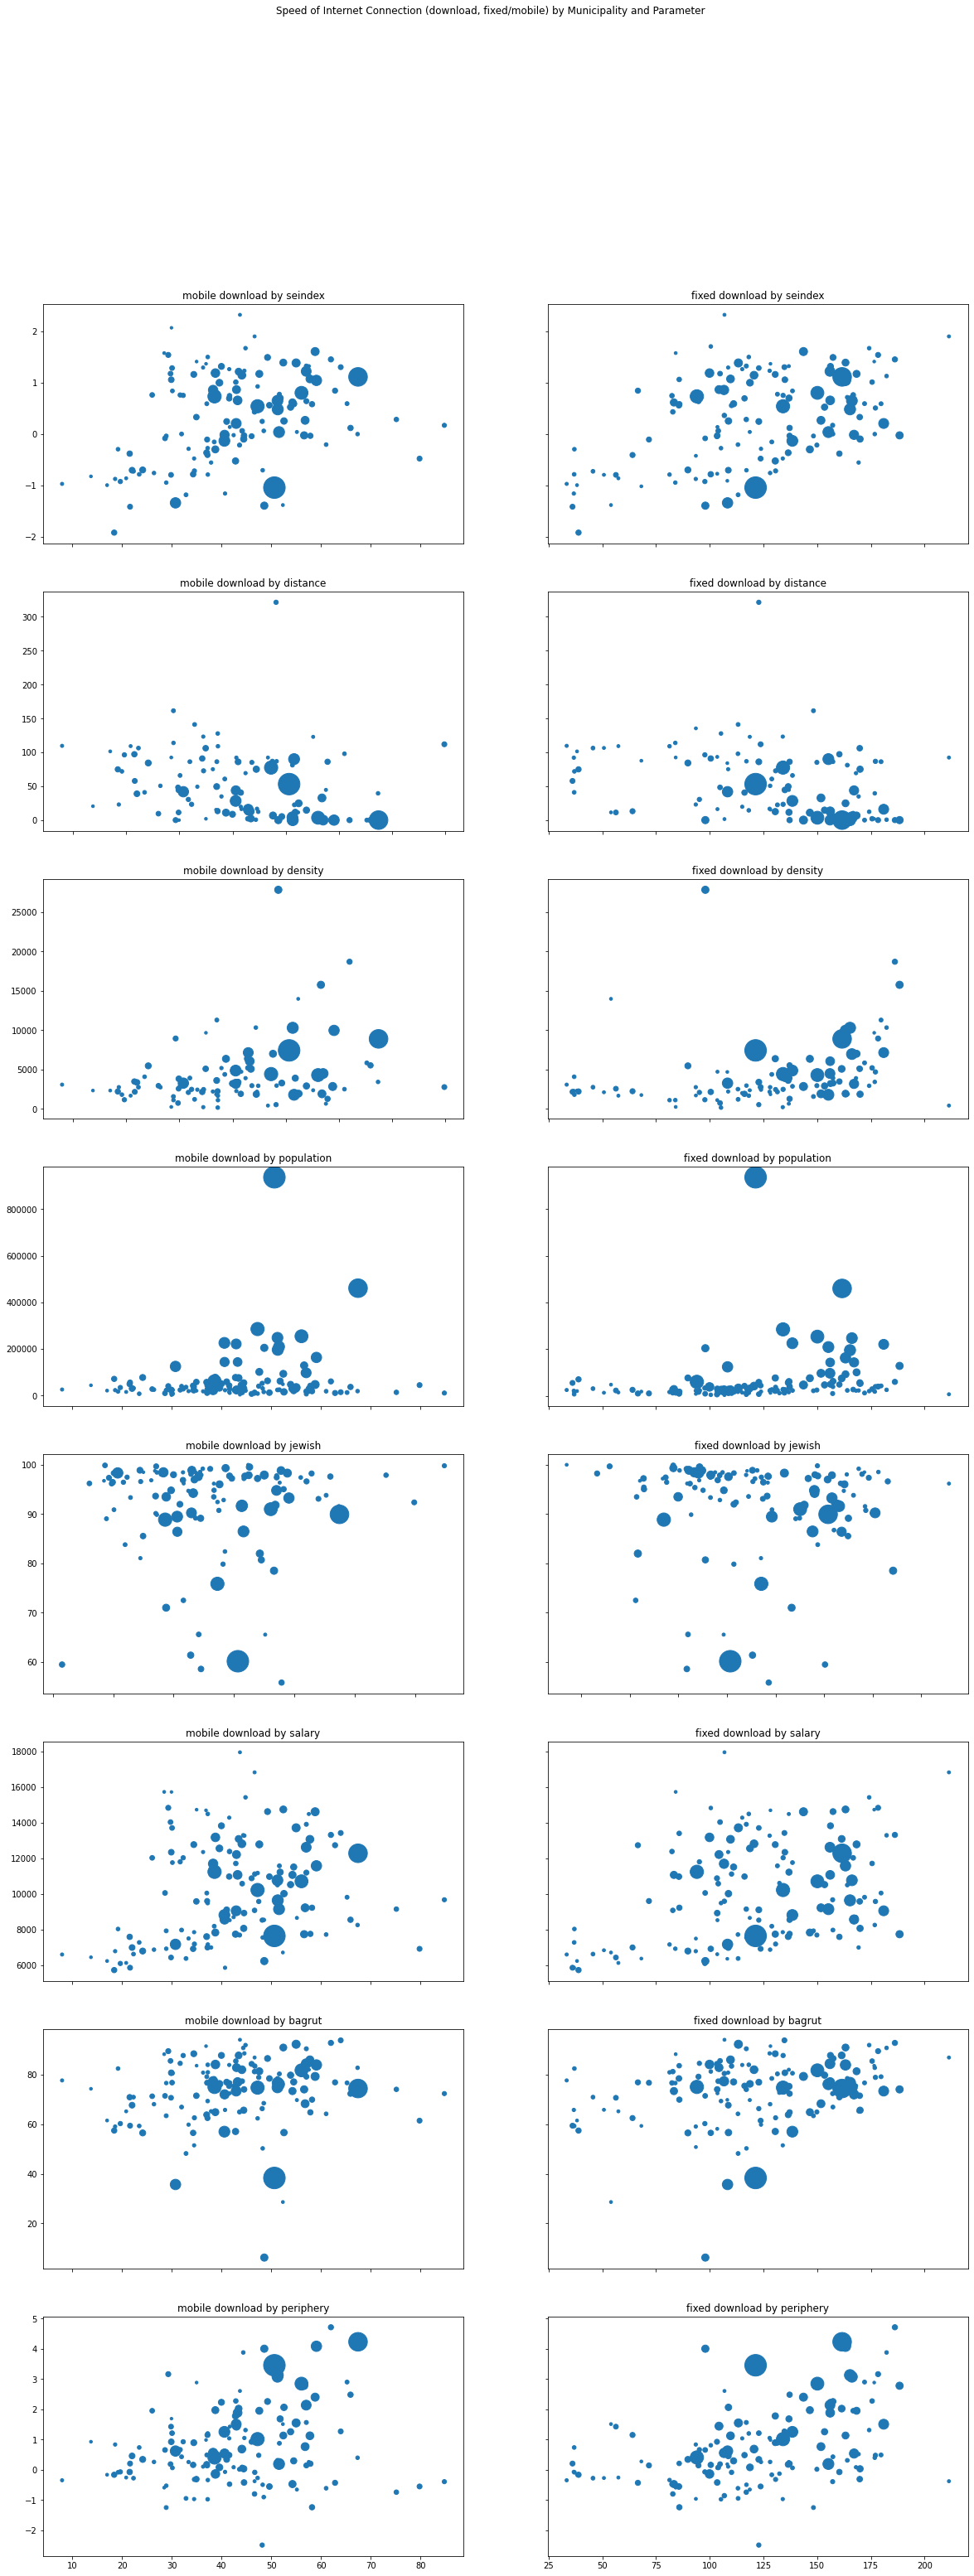

In [39]:
fig, plots = plt.subplots(8, 2)
fig.suptitle('Speed of Internet Connection (download, fixed/mobile) by Municipality and Parameter')


# for x, dir in enumerate(['download', 'upload', 'latency']):
for x, field in enumerate(['seindex', 'distance', 'density', 'population', 'jewish', 'salary', 'bagrut', 'periphery']):
    for y, type in enumerate(['mobile', 'fixed']):
        subres = [x for x in results if x['type'] == type and x['pop']]
        plots[x, y].scatter([x['d']/1000 for x in subres], [x[field] for x in subres], s=[x['pop']/1000 for x in subres], marker='o')
        plots[x, y].set_title(f'{type} download by {field}')


for ax in fig.get_axes():
    ax.label_outer()


- seindex: מדד סוציואקונומי
- distance: מרחק מגבול מחוז תל אביב (ק"מ)
- density: צפיפות אוכלוסייה לקמ''ר ביישובים שמנו 5,000 תושבים ויותר
- population: סה"כ  אוכלוסייה בסוף השנה
- jewish: יהודים (אחוזים)
- salary: שכר ממוצע לחודש של שכירים (ש"ח)
- bagrut: אחוז זכאים לתעודת בגרות מבין תלמידי כיתות יב
- periphery: מדד פריפריאליות (נמוך=פריפריה)
